In [17]:
from collections import Counter
import h5py
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [18]:
# Function to generate the training and test data
def generate_train_test_data(hdf5_out_put_file_path, train_percentage, n_pixels_lat, n_pixels_lon):
    # Open the HDF5 file
    with h5py.File(hdf5_out_put_file_path, 'r') as file:
        # Get all sequences from the file
        sequences = list(file.keys())
        n_sequences = len(sequences)
        
        # Calculate the number of training and test sequences
        n_train_sequences = int(train_percentage * n_sequences)
        n_train_samples = n_pixels_lat * n_pixels_lon * n_train_sequences
        n_test_sequences = n_sequences - n_train_sequences
        n_test_samples = n_pixels_lat * n_pixels_lon * n_test_sequences
        
        # Print information about the dataset
        print("n_train", n_train_sequences, "n_test", n_test_sequences)
        print("total number of sequences", n_train_sequences + n_test_sequences)
        print("n_sequences", n_sequences)
        print("n_train_samples", n_train_samples)
        print("n_test_samples", n_test_samples)
        
        # Initialize arrays for training and test data
        x_train = np.zeros((n_train_samples, 1))
        y_train = np.zeros(n_train_samples)
        x_test = np.zeros((n_test_samples, 1))
        y_test = np.zeros(n_test_samples)
        
        # Process training data
        sample_index = 0
        for i in range(n_train_sequences):
            group = file[sequences[i]]
            interpolated_displacement = group['interpolated_displacement'][()].reshape(-1, 5)
            
            # Remove masked pixels
            mask = interpolated_displacement[:, -1] == 1
            interpolated_displacement = interpolated_displacement[mask]
            labels = group['labels'][()].flatten()
            labels = labels[mask]
            
            print(interpolated_displacement)
            
            # Extract the relevant displacement data (4th column)
            interpolated_displacement = interpolated_displacement[..., 3]
            interpolated_displacement = interpolated_displacement.reshape(-1, 1)
            
            print(interpolated_displacement)
            
            # Store the data in the training arrays
            n_samples = interpolated_displacement.shape[0]
            x_train[sample_index:sample_index + n_samples] = interpolated_displacement
            y_train[sample_index:sample_index + n_samples] = labels
            sample_index += n_samples
        
        # Remove excess zeros from training data
        x_train = x_train[:sample_index]
        y_train = y_train[:sample_index]
        
        # Process test data
        sample_index = 0
        for i in range(n_train_sequences, n_sequences):
            group = file[sequences[i]]
            interpolated_displacement = group['interpolated_displacement'][()].reshape(-1, 5)
            
            # Remove masked pixels
            mask = interpolated_displacement[:, -1] == 1
            interpolated_displacement = interpolated_displacement[mask]
            labels = group['labels'][()].flatten()
            labels = labels[mask]
            
            # Extract the relevant displacement data (4th column)
            interpolated_displacement = interpolated_displacement[..., 3]
            interpolated_displacement = interpolated_displacement.reshape(-1, 1)
            
            # Store the data in the test arrays
            n_samples = interpolated_displacement.shape[0]
            x_test[sample_index:sample_index + n_samples] = interpolated_displacement
            y_test[sample_index:sample_index + n_samples] = labels
            sample_index += n_samples
        
        # Remove excess zeros from test data
        x_test = x_test[:sample_index]
        y_test = y_test[:sample_index]
    
    # Return the training and test data
    return x_train, y_train, x_test, y_test

# Parameters

In [19]:
#Path to the HDF5 output file
hdf5_out_put_file_path = "Data/Interpolated_Data_reg=False_soft_labels=False_elasticity=True_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1.hdf5"
train_percentage = 0.8
test_percentage = 1 - train_percentage
n_pixels_lat = 50  # Number of pixels in the latitude direction
n_pixels_lon = 50  # Number of pixels in the longitude direction

In [20]:
x_train, y_train, x_test, y_test = generate_train_test_data(hdf5_out_put_file_path, train_percentage, n_pixels_lat,
                                                            n_pixels_lon)

n_train 133 n_test 34
total number of sequences 167
n_sequences 167
n_train_samples 332500
n_test_samples 85000
[[-9.65612372e-01  2.24747889e+00  1.03348125e-01  9.23373532e+01
   1.00000000e+00]
 [-9.31634271e-01  2.24688545e+00  1.09756381e-01  8.85855313e+01
   1.00000000e+00]
 [-8.99843815e-01  2.24623867e+00  1.15368309e-01  8.48629292e+01
   1.00000000e+00]
 ...
 [-6.89374463e-01  2.22337719e+00  1.25157785e-01  1.22415604e+02
   1.00000000e+00]
 [-6.88271368e-01  2.22414911e+00  1.14085614e-01  1.21682591e+02
   1.00000000e+00]
 [-6.88708302e-01  2.22486431e+00  1.02946614e-01  1.21079552e+02
   1.00000000e+00]]
[[ 92.33735315]
 [ 88.58553127]
 [ 84.86292917]
 [ 81.17356781]
 [ 77.52219405]
 [ 73.91443868]
 [ 70.35701279]
 [ 66.85795157]
 [ 63.42691592]
 [ 60.07556298]
 [ 56.81799526]
 [ 53.67129306]
 [ 50.65612181]
 [ 47.79738056]
 [102.13173907]
 [ 98.25072489]
 [ 94.3854313 ]
 [ 90.53787263]
 [ 86.71041059]
 [ 82.90582944]
 [ 79.12743056]
 [ 75.37915209]
 [ 71.6657211 ]
 [ 6

# Oversampling the training set

In [21]:
# Oversampling the training set using SMOTE
oversampler = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

In [22]:
Counter(y_train_resampled)

Counter({0.0: 153584, 1.0: 153584})

Threshold  0.5523450436433562
ROC curve for the test set:


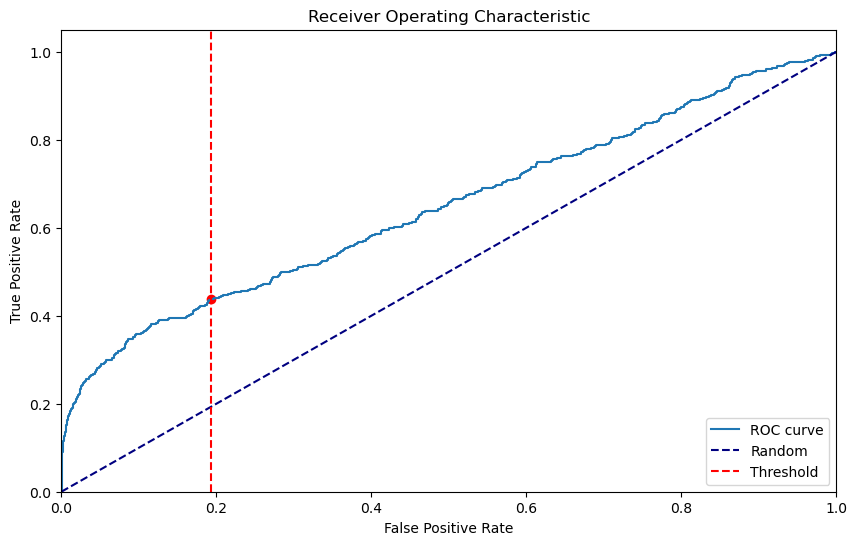

Test Results:
Accuracy: 0.8021
Balanced Accuracy: 0.6216
Recall: 0.4371
F1 Score: 0.0462
AUROC: 0.6464
AUPRC: 0.0810


In [23]:
class BootstrappedSoftVotingClassifier(BaseEstimator):
    # BaseEstimator is a base class for all estimators in scikit-learn
    # n_estimators is the number of base estimators to train
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.threshold_ = 0.5
        self.model_ids = []
        self.sample_to_models = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]
        
        for i in range(self.n_estimators):
            # Create a bootstrap sample by resampling with replacement
            indices = resample(range(n_samples), n_samples=n_samples)
            X_bootstrap, y_bootstrap = X[indices], y[indices]
            
            # Create and fit a new estimator
            estimator = clone(self.base_estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            
            self.estimators_.append(estimator)
            self.model_ids.append(i)
            
            unused_indices = set(range(n_samples)) - set(indices)
            # unused_indices is the set of indices that were not used to train the model i 
            for idx in unused_indices:
                if idx not in self.sample_to_models:
                    self.sample_to_models[idx] = []
                self.sample_to_models[idx].append(i)# i is the model id
                #sample_to_models[idx] is the list of model ids that were not trained on this sample


        avg_proba_train = self.predict_proba(X)
        fpr, tpr, thresholds = roc_curve(y, avg_proba_train[:, 1])
        # Find the optimal threshold that maximizes the difference between TPR and FPR
        self.threshold_ = thresholds[np.argmax(tpr - fpr)]
        print ("Threshold ", self.threshold_)
        return self

    def predict_proba(self, X):
        all_proba = []
        # For each sample, calculate the average predicted probability across all models that were not trained on that sample
        for i, sample in enumerate(X):
            sample = sample.reshape(1, -1)
            if i in self.sample_to_models:
                model_ids = self.sample_to_models[i]
                proba = np.mean([self.estimators_[j].predict_proba(sample) for j in model_ids], axis=0)
            else:
                proba = np.mean([est.predict_proba(sample) for est in self.estimators_], axis=0)
            all_proba.append(proba[0])
        return np.array(all_proba)

    def predict(self, X):
        avg_proba = self.predict_proba(X)
        avg_proba_pos = avg_proba[:, 1]
        y = (avg_proba_pos > self.threshold_).astype(int)
        return y



    def plot_predictions(self, X_test):
        # plot the median and mean predictions for the first 20 test samples
        all_predictions = []
        for estimator in self.estimators_:
            all_predictions.append(estimator.predict_proba(X_test)[:, 1])
        
        all_predictions = np.array(all_predictions)
        median_predictions = np.median(all_predictions, axis=0)
        mean_predictions = np.mean(all_predictions, axis=0)
        mean_predictions = mean_predictions[:20]
        median_predictions = median_predictions[:20]

        plt.figure(figsize=(12, 6))
        plt.scatter(range(20), median_predictions, marker='x', color='blue', label='Median', alpha=0.7)
        plt.scatter(range(20), mean_predictions, marker='x', color='red', label='Mean', alpha=0.7)
        plt.xlabel('Test Sample Index')
        plt.ylabel('Predicted Probability')
        plt.title('Median and Mean Predictions for Test Samples')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return median_predictions, mean_predictions

# def create_aftershock_map(lats, lons, values, title, cmap='coolwarm'):
#     plt.figure(figsize=(12, 8))
#     ax = plt.axes(projection=ccrs.PlateCarree())
    
#     # Add map features
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS)
#     ax.add_feature(cfeature.STATES)
    
#     # Set map extent
#     ax.set_extent([min(lons)-1, max(lons)+1, min(lats)-1, max(lats)+1], crs=ccrs.PlateCarree())
    
#     # Plot the data
#     sc = ax.scatter(lons, lats, c=values, cmap=cmap, s=50, alpha=0.7, transform=ccrs.PlateCarree())
    
#     plt.colorbar(sc, label='Aftershock Probability' if 'Predicted' in title else 'Aftershock Occurrence')
#     plt.title(title)
#     plt.show()

# def plot_aftershock_maps(X, y_true, y_pred):
#     # Assuming X contains latitude and longitude information in the first two columns
#     lats, lons = X[:, 0], X[:, 1]
    
#     # Plot ground truth
#     create_aftershock_map(lats, lons, y_true, "Ground Truth Aftershocks")
    
#     # Plot predictions
#     create_aftershock_map(lats, lons, y_pred, "Predicted Aftershocks")

    

def evaluate_bootstrapped_soft_voting(X_train, X_test, y_train, y_test, base_estimator, n_estimators=10):
    # Create and fit the bootstrapped soft voting classifier
    bsvc = BootstrappedSoftVotingClassifier(base_estimator, n_estimators)
    bsvc.fit(X_train, y_train)
    
    y_pred = bsvc.predict(X_test)
    y_prob = bsvc.predict_proba(X_test)
    
    y_prob_pos = y_prob[:, 1]



    y_prob_pos = y_prob[:, 1]
    
    print("ROC curve for the test set:")
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

    closest_threshold_index = np.argmin(np.abs(thresholds - bsvc.threshold_))
    closest_fpr = fpr[closest_threshold_index]
    closest_tpr = tpr[closest_threshold_index]
    plt.axvline(closest_fpr, color='red', linestyle='--', label='Threshold')
    plt.scatter(closest_fpr, closest_tpr, color='red')  

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    y_test2 = (y_test > bsvc.threshold_).astype(int)
    
    results = {
        'Accuracy': metrics.accuracy_score(y_test, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
        'Recall': metrics.recall_score(y_test, y_pred, average='binary'),
        'F1 Score': metrics.f1_score(y_test, y_pred, average='binary'),
        'AUROC': metrics.roc_auc_score(y_test, y_prob_pos),
        'AUPRC': metrics.average_precision_score(y_test, y_prob_pos)
    }
    median_predictions, mean_predictions = bsvc.plot_predictions(X_test)
    
    
    return results, bsvc

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]
class_weight_options = {0: 1, 1: scale_pos_weight}
base_estimator = LogisticRegression(random_state=42, n_jobs=-1, class_weight=class_weight_options)
results, classifier = evaluate_bootstrapped_soft_voting(x_train, x_test, y_train, y_test, base_estimator, n_estimators=100)

print("Test Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

# print("\nModel IDs:", classifier.model_ids)
# print("\nSample-to-models mapping (first 5 samples):")
# for i, models in list(classifier.sample_to_models.items())[:5]:
#     print(f"Sample {i}: {models}")